In [1]:
import sys
sys.path.append(r'C:\Users\allen\OneDrive\Documents\intern')
folder_path=r'C:\Users\allen\OneDrive\Documents\intern\batteries'
from nasa_functions import *
selected_files,remaining_files=partition_files(folder_path=folder_path,selected_files='CellB0006Cleaned.parquet')

C:\Users\allen\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\allen\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


Selected files: ['CellB0006Cleaned.parquet']
Remaining files: ['CellB0025Cleaned.parquet', 'CellB0056Cleaned.parquet', 'CellB0005Cleaned.parquet', 'CellB0036Cleaned.parquet', 'CellB0031Cleaned.parquet', 'CellB0052Cleaned.parquet', 'CellB0041Cleaned.parquet', 'CellB0034Cleaned.parquet', 'CellB0026Cleaned.parquet', 'CellB0050Cleaned.parquet', 'CellB0039Cleaned.parquet', 'CellB0007Cleaned.parquet', 'CellB0053Cleaned.parquet', 'CellB0033Cleaned.parquet', 'CellB0027Cleaned.parquet', 'CellB0043Cleaned.parquet', 'CellB0030Cleaned.parquet', 'CellB0055Cleaned.parquet', 'CellB0054Cleaned.parquet', 'CellB0032Cleaned.parquet', 'CellB0018Cleaned.parquet', 'CellB0038Cleaned.parquet', 'CellB0049Cleaned.parquet', 'CellB0042Cleaned.parquet', 'CellB0051Cleaned.parquet', 'CellB0044Cleaned.parquet', 'CellB0028Cleaned.parquet', 'CellB0029Cleaned.parquet', 'CellB0040Cleaned.parquet']


selected_files=['CellB0005Cleaned.parquet']
remaining_files=['CellB0006Cleaned.parquet','CellB0007Cleaned.parquet']

In [2]:
nasa=pd.concat([pd.read_parquet(f"{folder_path}\{file}") for file in remaining_files],ignore_index=True)
nasa2=pd.concat([pd.read_parquet(f"{folder_path}\{file}") for file in selected_files],ignore_index=True)

In [3]:
nasa=nasa.fillna(0)
#print(nasa.describe())
nasa2=nasa2.fillna(0)
#print(nasa2.describe())

C:\Users\allen\AppData\Local\Temp\ipykernel_12496\445149997.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  nasa=nasa.fillna(0)
C:\Users\allen\AppData\Local\Temp\ipykernel_12496\445149997.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  nasa2=nasa2.fillna(0)


In [4]:
plt.figure(figsize=(5,5))
cycles=nasa["Cycle"].unique()
if nasa.loc[0,"Cycle_Type"]=="charge":# remove anomolous
    nasa=nasa[nasa["Cycle"]>2]
else:
    nasa=nasa[nasa["Cycle"]>3]
if nasa2.loc[0,"Cycle_Type"]=="charge":
    nasa2=nasa2[nasa2["Cycle"]>2]
else:
    nasa2=nasa2[nasa2["Cycle"]>3]

<Figure size 360x360 with 0 Axes>

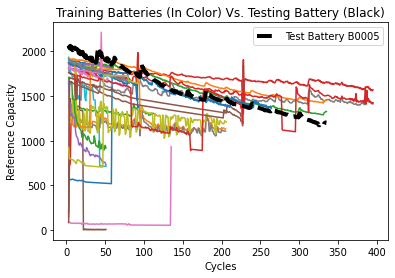

In [5]:
for cell in nasa["Cell"].unique():
    nasa_temp=nasa[nasa["Cell"]==cell]
    plt.plot(nasa_temp["Cycle"],nasa_temp["Reference Capacity"])
plt.plot(nasa2["Cycle"],nasa2["Reference Capacity"],lw=4,linestyle="--",label="Test Battery B0005",color="black")
plt.legend(loc="upper right")
plt.xlabel("Cycles")
plt.ylabel("Reference Capacity")
plt.title("Training Batteries (In Color) Vs. Testing Battery (Black)")
plt.savefig("testtrain.png",dpi=300)

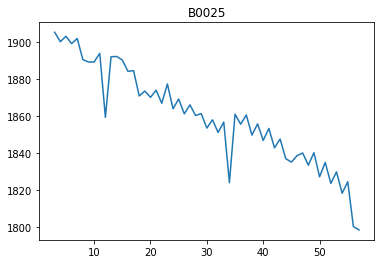

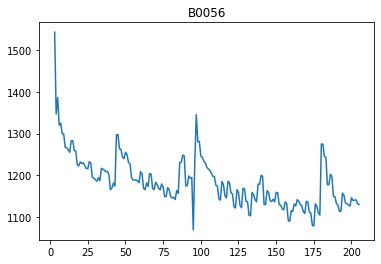

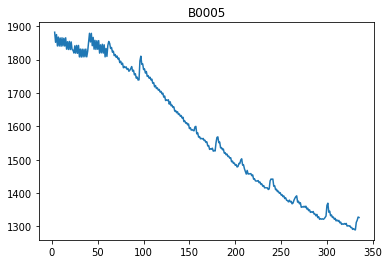

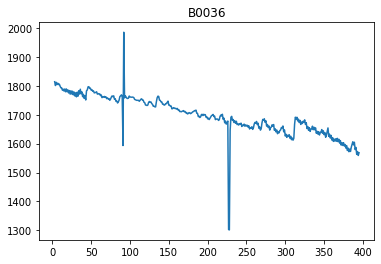

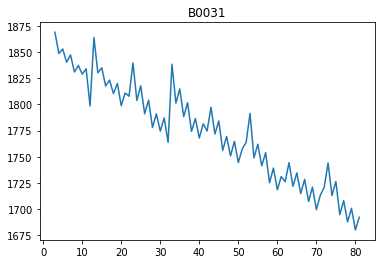

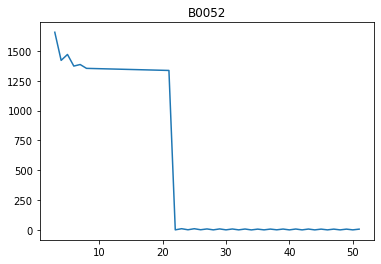

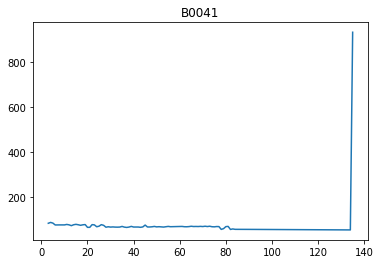

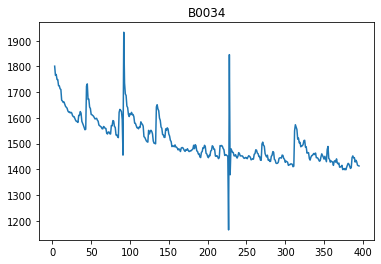

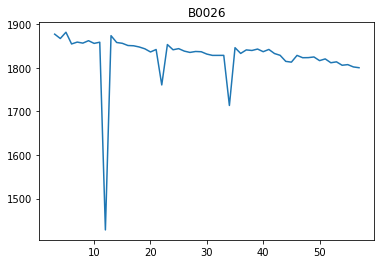

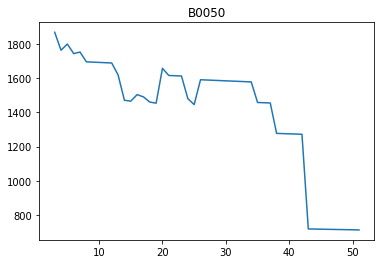

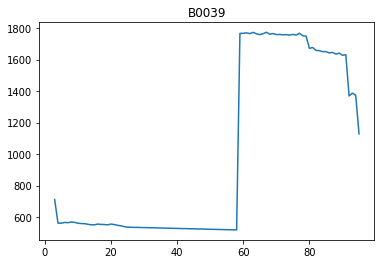

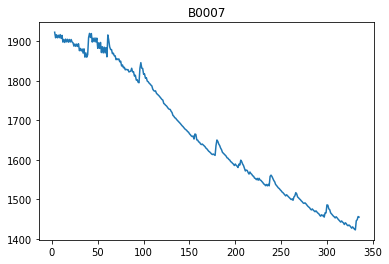

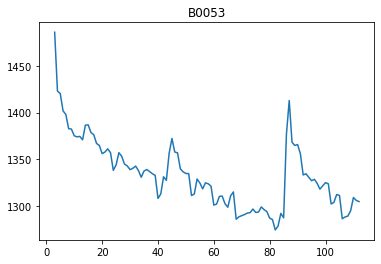

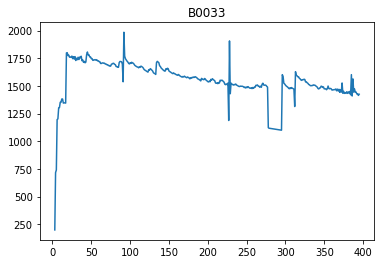

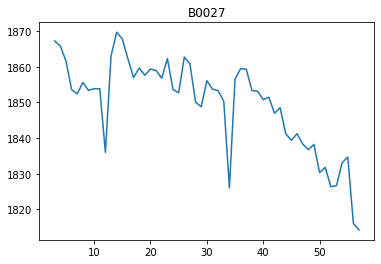

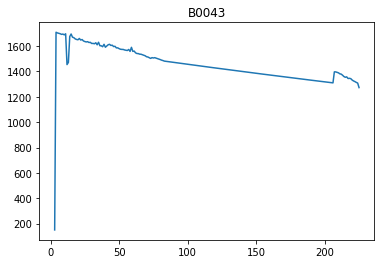

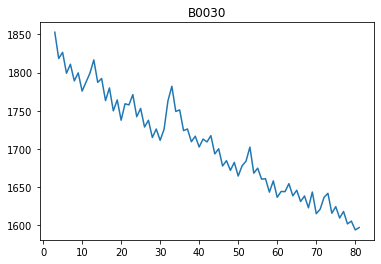

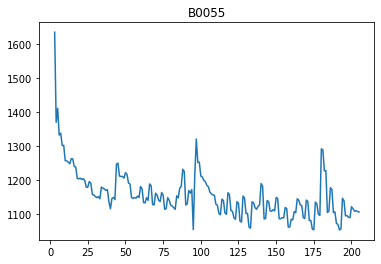

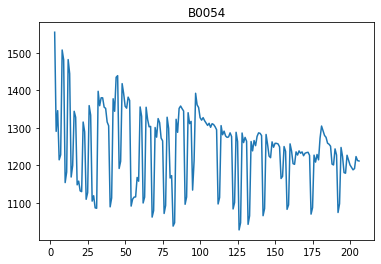

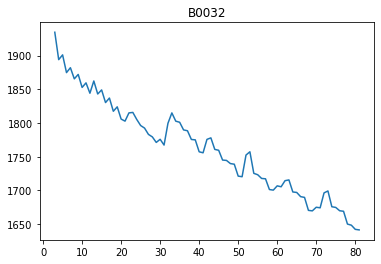

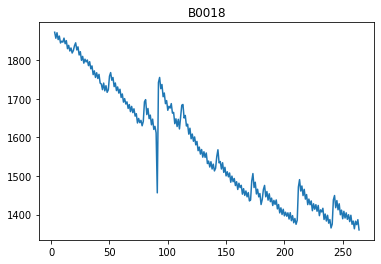

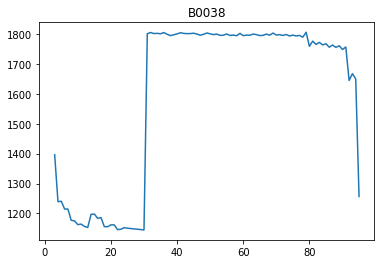

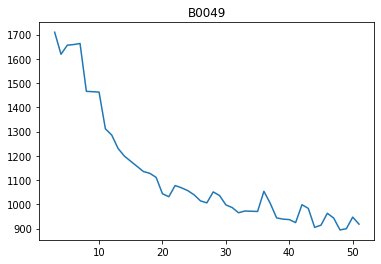

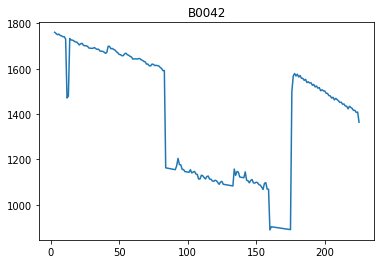

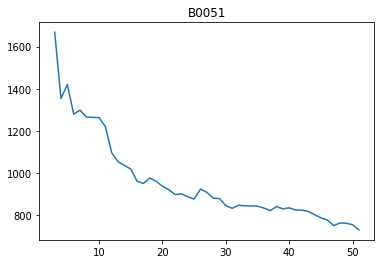

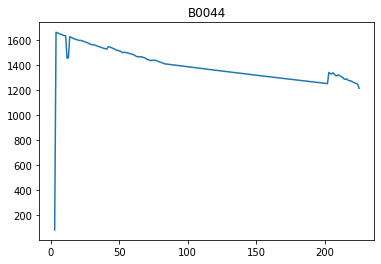

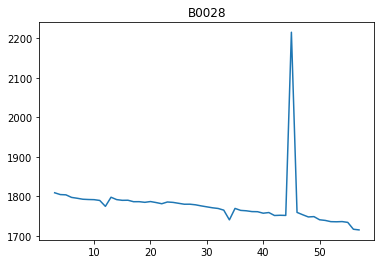

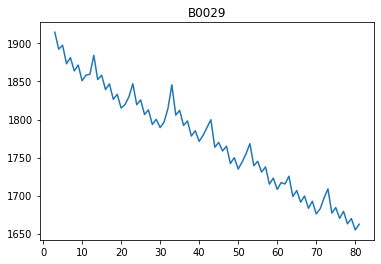

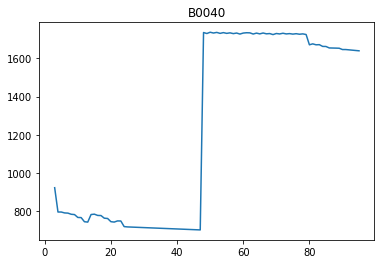

In [6]:
for cell in nasa["Cell"].unique():
    nasa_temp=nasa[nasa["Cell"]==cell]
    plt.plot(nasa_temp["Cycle"],nasa_temp["Reference Capacity"])
    plt.title(cell)
    plt.show()


In [7]:
from sklearn.preprocessing import StandardScaler
SS=StandardScaler()
nasa[["Current","Voltage","Temperature"]]=SS.fit_transform(nasa[["Current","Voltage","Temperature"]])
nasa2[["Current","Voltage","Temperature"]]=SS.transform(nasa2[["Current","Voltage","Temperature"]])

In [8]:
volt,temp,curr,mat,ambients,discharges,sohs=create_matrix(nasa=nasa)
volt_2,temp_2,curr_2,mat_2,ambients_2,discharges_2,sohs_2=create_matrix(nasa=nasa2)

(2000, 4640)
(2000, 333)


In [9]:
mat.shape

(6000, 4640)

scoremat_complete=make_fpc_complete(mat,ambients,num_components=2)

scoremat_complete.shape

scoremat_complete_2=make_fpc_complete(mat_2,ambients_2,num_components=2,func="transform")

In [10]:
scoremat=make_fpc(volt=volt,curr=curr,temp=temp,func='fit_transform',ambients=ambients)

Creating Objects
Smoothing
Getting Components
Fitting
Getting Scores


In [11]:
scoremat_2=make_fpc(volt=volt_2,curr=curr_2,temp=temp_2,func='transform',ambients=ambients_2)

Creating Objects
Smoothing
Getting Components
Fitting
Getting Scores


volt.shape

In [12]:
from sklearn.ensemble import RandomForestRegressor as RF
scores=[]

for n in range(1,20):

    forest1=RF(n_estimators=n,random_state=120)
    forest1.fit(scoremat,discharges)

    y_pred=forest1.predict(scoremat_2)
    score=forest1.score(scoremat_2,discharges_2)
    scores.append(score)
    print(n,score)
print(f"Best Estimators:{np.argmax(scores)+1} with score {scores[np.argmax(scores)]}") 

1 0.8825597145854477
2 0.7582190249231224
3 0.6591553243334832
4 0.755378946414588
5 0.7782077973507682
6 0.8093280511358811
7 0.8173688078664259
8 0.8274568499078685
9 0.8242121343268398
10 0.8278038540020645
11 0.8372084530629821
12 0.8289801476028493
13 0.8375408292361135
14 0.8390155350740132
15 0.8430404652481869
16 0.8433134022453823
17 0.8338284322871257
18 0.8451789112749555
19 0.8325225051674281
Best Estimators:1 with score 0.8825597145854477


from sklearn.ensemble import RandomForestRegressor as RF
complete_scores=[]

for n in range(1,20):

    forest1=RF(n_estimators=n,random_state=120)
    forest1.fit(scoremat_complete,discharges)

    y_pred=forest1.predict(scoremat_complete_2)
    score=forest1.score(scoremat_complete_2,discharges_2)
    complete_scores.append(score)
    print(n,score)
print(f"Best Estimators:{np.argmax(scores)+1} with score {complete_scores[np.argmax(complete_scores)]}") 

In [13]:
best_num=np.argmax(scores)+1

In [14]:
forest1=RF(n_estimators=best_num,random_state=120)
forest1.fit(scoremat,discharges)

y_pred1=forest1.predict(scoremat_2)
forest1.score(scoremat_2,discharges_2)

0.8825597145854477

In [15]:
names=[["voltage","current","temperature"][a] +str(b) for a in range(3) for b in range(2)]
names.append("Ambient")
for c in range(7):
    print(names[c])
    print(f"{forest1.feature_importances_[c]:.3f}")

voltage0
0.050
voltage1
0.154
current0
0.065
current1
0.241
temperature0
0.086
temperature1
0.051
Ambient
0.353


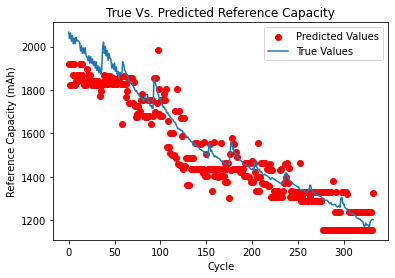

In [16]:
plt.scatter(range(len(y_pred1)),y_pred1,label="Predicted Values",color="red")
plt.plot(range(len(y_pred1)),discharges_2,label="True Values")
plt.title("True Vs. Predicted Reference Capacity")
plt.xlabel("Cycle")
plt.ylabel("Reference Capacity (mAh)")
plt.legend()
plt.savefig("results.png",dpi=300)

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(discharges_2, y_pred1)
rmse = np.sqrt(mean_squared_error(y_pred1,discharges_2 ))
rmsep=100*rmse/np.mean(discharges_2)
print("MAE:", mae)
print("RMSE:", rmse)
print("RMSEP:",rmsep)

MAE: 71.5011951951952
RMSE: 86.24813735872706
RMSEP: 5.527363054515534


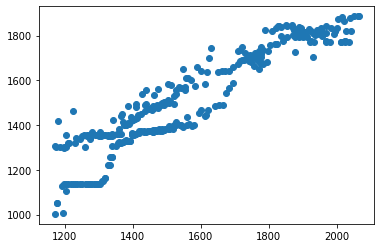

In [18]:
plt.scatter(discharges_2,y_pred)
min_,max_=np.min(discharges_2),np.max(discharges_2)


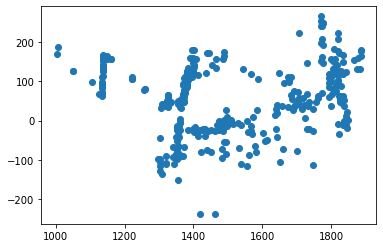

In [19]:
plt.scatter(y_pred,discharges_2-y_pred)
#plt.xlim(1780,1900)
#plt.ylim(-40,40)

In [20]:
from sklearn.ensemble import RandomForestRegressor as RF

scores=[]
diffscores=[]
y_preds=[]
y_preds_diff=[]
for part in range(10):
    partition=[part*200,part*200 +199]
    volt,temp,curr,mat,ambients,discharges,sohs=create_matrix(nasa=nasa,partition=partition)
    diffed=np.diff(discharges)
    diffed=np.insert(diffed,-1,0)
    print(f"Got matrix 1 for observations {partition[0]} through {partition[1]}")
    volt_2,temp_2,curr_2,mat_2,ambients_2,discharges_2,sohs_2=create_matrix(nasa=nasa2,partition=partition)
    diffed_2=np.diff(discharges_2)
    diffed_2=np.insert(diffed_2,-1,0)
    print(f"Got matrix 2 for observations {partition[0]} through {partition[1]}")
    scoremat=make_fpc(volt=volt,curr=curr,temp=temp,func='fit_transform',ambients=ambients)
    scoremat_2=make_fpc(volt=volt_2,curr=curr_2,temp=temp_2,func='transform',ambients=ambients_2)
    print("Got Components")
    forest=RF(n_estimators=best_num,random_state=120)
    forest.fit(scoremat,discharges)
    
    for c in range(7):
        print(names[c])
        print(f"{forest.feature_importances_[c]:.3f}")
    y_pred=forest.predict(scoremat_2)
    y_preds.append(y_pred)
    score=forest.score(scoremat_2,discharges_2)
    scores.append(score)
    print(f"Capacity Prediction Score for {partition} is {score}")
    forest_diff=RF(n_estimators=best_num,random_state=120)
    forest_diff.fit(scoremat,diffed)
    for c in range(7):
        print(names[c])
        print(f"{forest_diff.feature_importances_[c]:.3f}")
    y_pred_diff=forest_diff.predict(scoremat_2)
    y_preds_diff.append(y_pred_diff)
    diffscore=forest_diff.score(scoremat_2,diffed_2)
    diffscores.append(diffscore)
    print(f"Capacity Loss Score for {partition} is {diffscore}")
    
    
    

(199, 4640)
Got matrix 1 for observations 0 through 199
(199, 333)
Got matrix 2 for observations 0 through 199
Creating Objects
Smoothing
Getting Components
Fitting
Getting Scores
Creating Objects
Smoothing
Getting Components
Fitting
Getting Scores
Got Components
voltage0
0.240
voltage1
0.165
current0
0.093
current1
0.063
temperature0
0.042
temperature1
0.040
Ambient
0.357
Capacity Prediction Score for [0, 199] is 0.7496889209767174
voltage0
0.098
voltage1
0.331
current0
0.192
current1
0.059
temperature0
0.131
temperature1
0.189
Ambient
0.001
Capacity Loss Score for [0, 199] is -33.68472496801398
(199, 4640)
Got matrix 1 for observations 200 through 399
(199, 333)
Got matrix 2 for observations 200 through 399
Creating Objects
Smoothing
Getting Components
Fitting
Getting Scores
Creating Objects
Smoothing
Getting Components
Fitting
Getting Scores
Got Components
voltage0
0.276
voltage1
0.096
current0
0.093
current1
0.051
temperature0
0.074
temperature1
0.048
Ambient
0.363
Capacity Predict

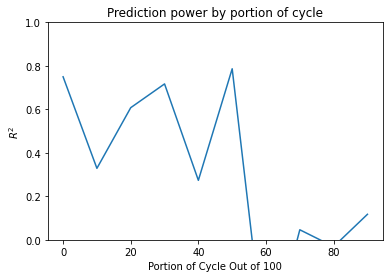

In [21]:
plt.plot(np.arange(0,100,10),np.array(scores))
plt.title("Prediction power by portion of cycle")
plt.xlabel("Portion of Cycle Out of 100")
plt.ylabel("$R^2$")
plt.ylim(0,1)
plt.savefig("gradient.png")
plt.show()



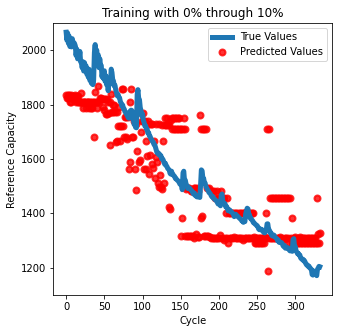

<Figure size 432x288 with 0 Axes>

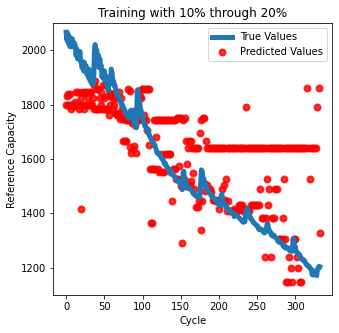

<Figure size 432x288 with 0 Axes>

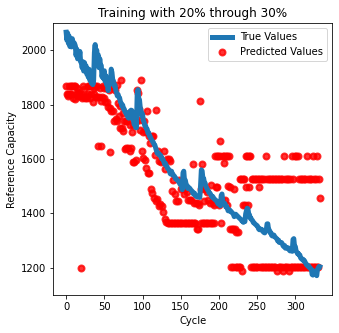

<Figure size 432x288 with 0 Axes>

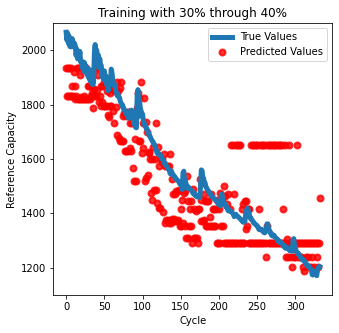

<Figure size 432x288 with 0 Axes>

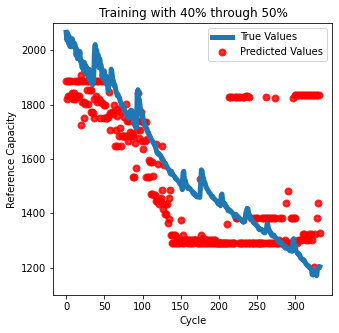

<Figure size 432x288 with 0 Axes>

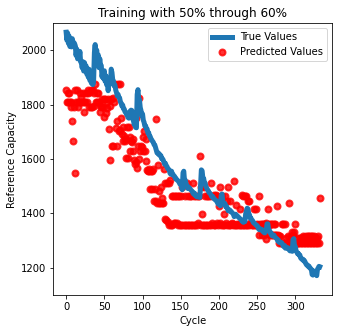

<Figure size 432x288 with 0 Axes>

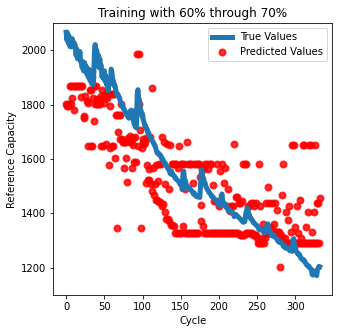

<Figure size 432x288 with 0 Axes>

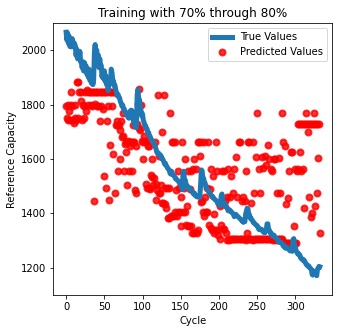

<Figure size 432x288 with 0 Axes>

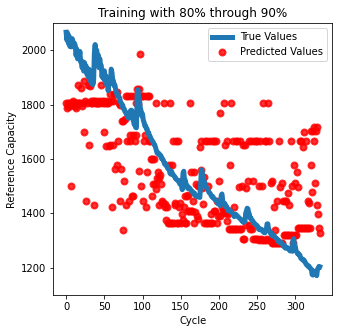

<Figure size 432x288 with 0 Axes>

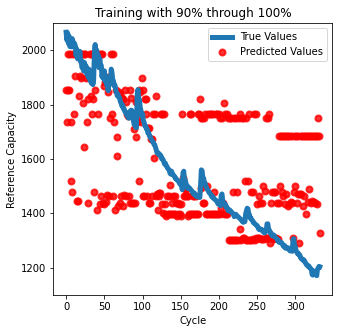

<Figure size 432x288 with 0 Axes>

In [22]:

for val in range(10):
    plt.figure(figsize=(5,5))
    plt.plot(discharges_2,lw=5,label="True Values")
    plt.scatter(range(len(y_preds[val])),y_preds[val],lw=2,color="red",alpha=.8,label="Predicted Values")
    plt.title(f"Training with {val*10}% through {val*10+10}%")
    plt.xlabel("Cycle")
    plt.ylabel("Reference Capacity")
    plt.ylim(1100,2100)
    plt.legend(loc="upper right")
    plt.savefig(f"plot{val}.png",dpi=200)
    plt.show()
    plt.tight_layout()

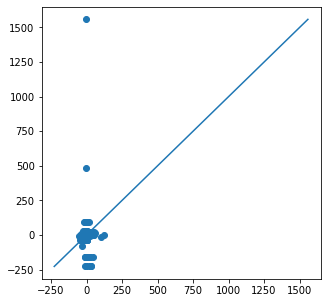

<Figure size 432x288 with 0 Axes>

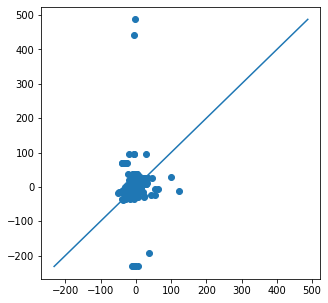

<Figure size 432x288 with 0 Axes>

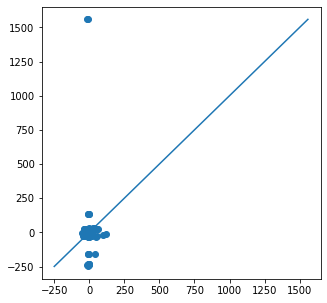

<Figure size 432x288 with 0 Axes>

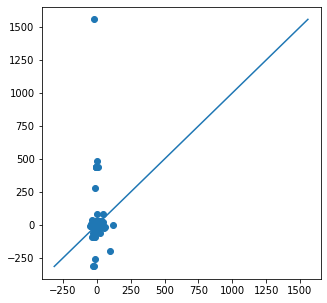

<Figure size 432x288 with 0 Axes>

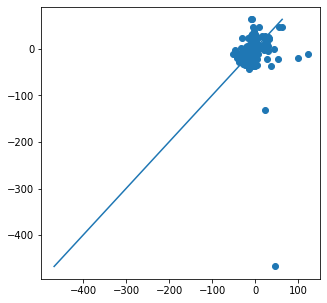

<Figure size 432x288 with 0 Axes>

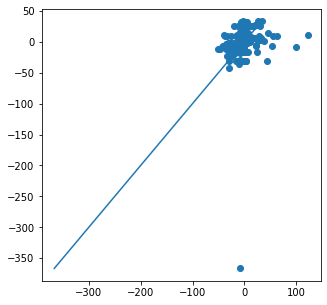

<Figure size 432x288 with 0 Axes>

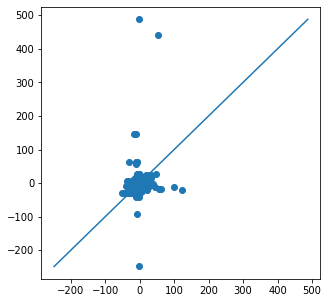

<Figure size 432x288 with 0 Axes>

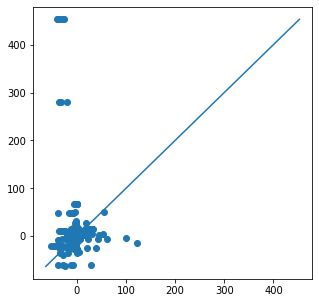

<Figure size 432x288 with 0 Axes>

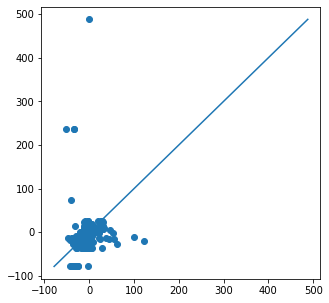

<Figure size 432x288 with 0 Axes>

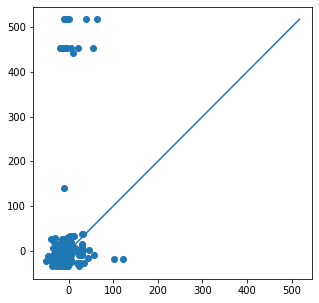

<Figure size 432x288 with 0 Axes>

In [23]:
%matplotlib inline
for val in range(10):
    plt.figure(figsize=(5,5))
    plt.scatter(diffed_2,y_preds_diff[val])
    min,max=np.min(y_preds_diff[val]),np.max(y_preds_diff[val])
    plt.plot((min,max),(min,max))
    plt.show()
    plt.tight_layout()

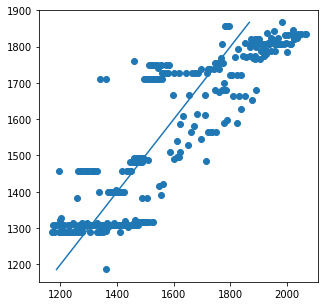

<Figure size 432x288 with 0 Axes>

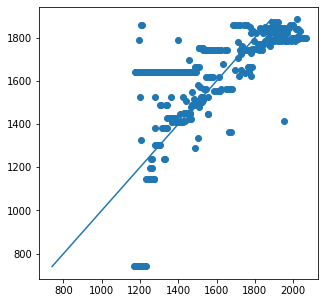

<Figure size 432x288 with 0 Axes>

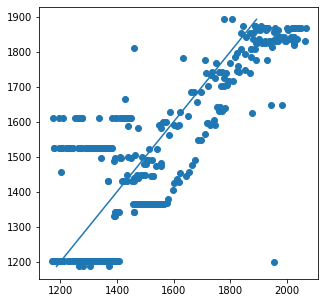

<Figure size 432x288 with 0 Axes>

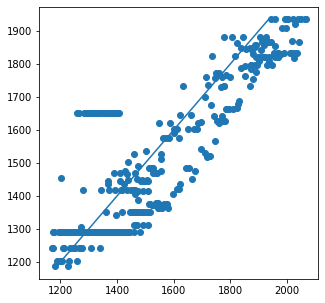

<Figure size 432x288 with 0 Axes>

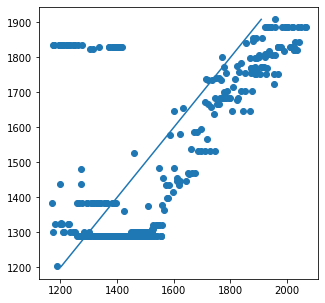

<Figure size 432x288 with 0 Axes>

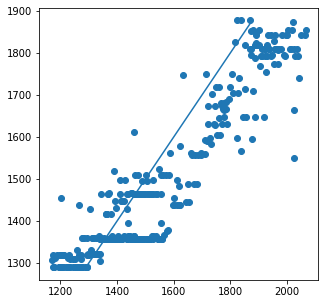

<Figure size 432x288 with 0 Axes>

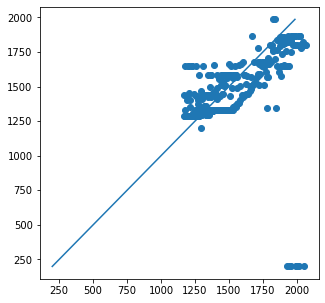

<Figure size 432x288 with 0 Axes>

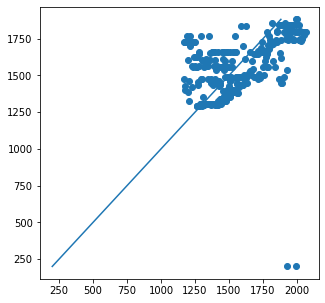

<Figure size 432x288 with 0 Axes>

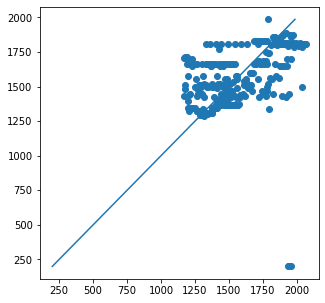

<Figure size 432x288 with 0 Axes>

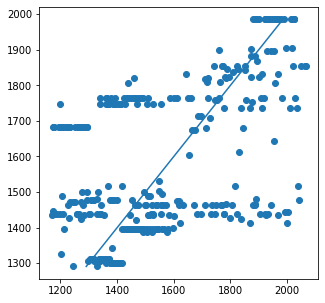

<Figure size 432x288 with 0 Axes>

In [24]:
%matplotlib inline
for val in range(10):
    plt.figure(figsize=(5,5))
    plt.scatter(discharges_2,y_preds[val])
    min,max=np.min(y_preds[val]),np.max(y_preds[val])
    plt.plot((min,max),(min,max))
    plt.show()
    plt.tight_layout()

In [25]:
plt.scatter(diffed_2,residual_diff)

NameError: name 'residual_diff' is not defined

In [ ]:
volt,temp,curr,mat,ambients,sohs,discharges=create_matrix(nasa=nasa)
volt_2,temp_2,curr_2,mat_2,ambients_2,sohs_2,discharges_2=create_matrix(nasa=nasa2)

In [ ]:
5000/(1+())